# Problem statement
The purpose of this project is transforming the style of given photos into monet pictures like style.  
For to do that GAN model is required.  
GAM model has two sub models and they are called generator and discriminator.  
The generator creates new images with given photo and the discriminator classify if given data is real or fake.  
The generator learns how to create images by losses from discriminator.  
The losses used in this model is like below.  
* generation loss:  
    Compare discriminator result with label 1. Generated image should fool discriminator so that discriminator classify it as real.  
* discrimination loss:  
    Mean of two losses. loss from classification for real and loss from classification for fake(generator created).
* cycle loss:  
    Compare image that generator created and real one. It gives hint to maintain aspect of original image.  

# Data summary
Learn monet style with Monet images and transfrom photos for submission.  
- Monet images: 300 pcs  
- Photos: 7028 pcs

# Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
# from kaggle_datasets import KaggleDatasets
from torch.utils.data import random_split, Dataset, DataLoader, random_split, Dataset, Subset
from torchvision.io import decode_image
from torchvision.transforms import ToTensor
import torch
from glob import glob
import os
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split
import torchvision.datasets as dset
import torchvision
from torchvision.transforms import ToTensor, Resize, Compose

# Set random seed for reproductivity

In [2]:
if torch.cuda.is_available():
    print("cuda is available")
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
else:
    print("there is no cuda")
    torch.manual_seed(0)

np.random.seed(0)

cuda is available


# Initiate wandb for logging

In [3]:
# wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
wandb.init(
  mode='disabled',
  # Set the project where this run will be logged
  project="Monet image gan project2",
  resume="allow",
  # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
  name="Test17",
  # Track hyperparameters and run metadata
  config={
      "learning_rate": 0.0001,
      "batch_size":16,
      "latent_dim":100,
      "b1":0.5,
      "b2":0.999,
      'n_blocks':3,
      'n_layers':3,
      'epochs':600,
      'cycle_loss_weight':10,
      'identity_loss_weight':10
  })
wandb_logger = WandbLogger()

wandb: Currently logged in as: respwill. Use `wandb login --relogin` to force relogin


# Set dataset
Dataset class load data from kaggle datasource and perform some transformation.  
I performed resize and normalization.  
The normalization process turn the image tensor into tensor that has values from -1 to 1.  

In [6]:
class MonetDataset(Dataset):
    def __init__(self, monet_file_paths, photo_file_paths, image_size=(256, 256)):
        self.monet_file_paths = monet_file_paths
        self.photo_file_paths = photo_file_paths
        self.transform = Compose([
            Resize(image_size),  # Resize images to a consistent size
            ToTensor(),  # Convert PIL image to a PyTorch tensor
        ])

    def __len__(self):
        return min(len(self.monet_file_paths), len(self.photo_file_paths))

    def __getitem__(self, idx):
        try:
            # Load and transform the Monet image
            monet_image_path = self.monet_file_paths[idx]
            monet_image = Image.open(monet_image_path).convert("RGB")  # Ensure RGB mode
            monet_image = self.transform(monet_image)
            monet_image = (monet_image * 2) - 1  # Normalize to [-1, 1]

            # Load and transform the Photo image
            photo_image_path = self.photo_file_paths[idx]
            photo_image = Image.open(photo_image_path).convert("RGB")  # Ensure RGB mode
            photo_image = self.transform(photo_image)
            photo_image = (photo_image * 2) - 1  # Normalize to [-1, 1]

        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None  # Handle the error and skip this pair

        return monet_image, photo_image

## Dataset for submission
For the submission, I don't need monet data so I define another dataset class that returns photo data only.  

In [7]:
class SubmitMonetDataset(Dataset):
    def __init__(self, photo_file_paths, image_size=(256, 256)):
        self.photo_file_paths = photo_file_paths
        self.transform = Compose([
            Resize(image_size),  # Resize images to a consistent size
            ToTensor(),  # Convert PIL image to a PyTorch tensor
        ])

    def __len__(self):
        return len(self.photo_file_paths)

    def __getitem__(self, idx):
        try:
            # Load and transform the Photo image
            photo_image_path = self.photo_file_paths[idx]
            photo_image = Image.open(photo_image_path).convert("RGB")  # Ensure RGB mode
            photo_image = self.transform(photo_image)
            photo_image = (photo_image * 2) - 1  # Normalize to [-1, 1]

        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None  # Handle the error and skip this pair

        return photo_image

### Data loading check
I checked if data is correctly loaded.  

In [8]:
monet_filenames = glob(os.path.join('../input/gan-getting-started', 'monet_jpg', '*.jpg'))
photo_filenames = glob(os.path.join('../input/gan-getting-started', 'photo_jpg', '*.jpg'))

In [9]:
monet_filenames[:1]

['../input/gan-getting-started/monet_jpg/f4413e97bd.jpg']

In [10]:
photo_filenames[:1]

['../input/gan-getting-started/photo_jpg/fb97febc5f.jpg']

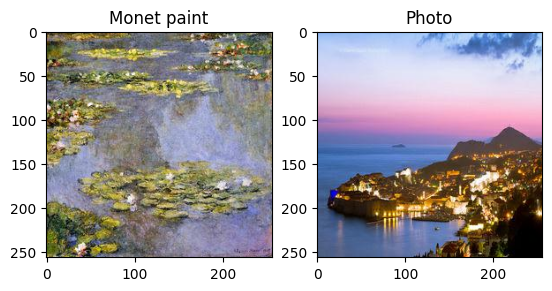

In [11]:
m_folder = monet_filenames[0].split("/")[3]
m_file = monet_filenames[0].split("/")[4]
my_monet = np.array(Image.open(f'../input/gan-getting-started/{m_folder}/{m_file}'))

p_folder = photo_filenames[1].split("/")[3]
p_file = photo_filenames[1].split("/")[4]
my_photo = np.array(Image.open(f'../input/gan-getting-started/{p_folder}/{p_file}'))

plt.subplot(121)
plt.title('Monet paint')
plt.imshow(my_monet)

plt.subplot(122)
plt.title('Photo')
plt.imshow(my_photo)

# Set data module
The data module is class that handles various types of dataloader that model uses while each steps.  
In the data module, I split the dataset into train, validation, and test set.  
(But I realzied that It may be not necessary for this project since we don't have any labels while I summarize this report.)  

In [12]:
def train_val_dataset(dataset, train_split=0.75, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), train_size=train_split, test_size=val_split, random_state=42)
    datasets = {'train':Subset(dataset, train_idx), 'val':Subset(dataset, val_idx)}
    return datasets

In [13]:
class MonetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        # get gcs path
        # self.gcs_path = KaggleDatasets().get_gcs_path()
        self.monet_filenames = glob(os.path.join('../input/gan-getting-started', 'monet_jpg', '*.jpg'))
        self.photo_filenames = glob(os.path.join('../input/gan-getting-started', 'photo_jpg', '*.jpg'))

    def setup(self, stage):
        dataset = MonetDataset(self.monet_filenames, self.photo_filenames)
        dataset = train_val_dataset(dataset)
        self.test_dataset = dataset['val']
        monet_dataset = train_val_dataset(dataset['train'])
        self.train_dataset = dataset['train']
        self.val_dataset = dataset['val']

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)

    def predict_dataloader(self):
        pass

Another datamodule that returns photo data only.

In [14]:
class SubmitMonetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.photo_filenames = glob(os.path.join('../input/gan-getting-started', 'photo_jpg', '*.jpg'))

    def setup(self, stage):
        self.dataset = SubmitMonetDataset(self.photo_filenames)

    def predict_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=3)

In [15]:
from torch import nn
from torch.nn import init
import functools

# Set generator and discriminator
These models are mainfunctionarity of GAN model.  
Briefly, GAN model learn as generator and discriminator competes.  

In [16]:
class Generator(pl.LightningModule):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect', name=''):
        super(Generator, self).__init__()
        self.name = name
        # self.img_shape = img_shape
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
#         if len(input.shape) == 1:
#             input = input.unsqueeze(0)
        img = self.model(input)
        # print(f"{self.name} Generator foward requires grad:")
        # print(img.requires_grad)
        # change shape of tensor from network
        # size(0)->batch size?
        # img = img.view(img.size(0), *self.img_shape)
        return img

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [17]:
class Discriminator(pl.LightningModule):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=4, dilation=3)]  # output 1 channel prediction map
        sequence += [nn.Sigmoid()]
        self.model = nn.Sequential(*sequence)
        self.model.apply(self.init_func)

        self.fc = nn.Linear(1, 1)

    def init_func(self, m):  # define the initialization function
        init_type='normal'
        init_gain=0.02
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    def forward(self, input):
        """Standard forward."""
        x = self.model(input)
        x = torch.mean(x, dim=(2, 3))  # Global Average Pooling
        x = self.fc(x)
        return torch.sigmoid(x)

# Build Cycle GAN model
Build GAN model as including generator and discriminator for photos and images.  
For simplicity, I separated foward method as generator forward and discriminator foward.  
The generator and discriminator works in each forward method and losses are calculated in training step.  
Backward (network update) is done in training step.  

In [18]:
class GAN(pl.LightningModule):
    def __init__(self, channels, width, height, lr, b1, b2, batch_size):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        data_shape = (channels, width, height)
        self.monet_generator = Generator(input_nc=channels, output_nc=channels,
                                         ngf=wandb.config['batch_size'], norm_layer=nn.BatchNorm2d,
                                         use_dropout=False, n_blocks=wandb.config['n_blocks'],
                                         padding_type='reflect',
                                         name='monet')
        self.photo_generator = Generator(input_nc=channels, output_nc=channels,
                                         ngf=wandb.config['batch_size'], norm_layer=nn.BatchNorm2d,
                                         use_dropout=False, n_blocks=wandb.config['n_blocks'],
                                         padding_type='reflect',
                                         name='photo')
        self.monet_discriminator = Discriminator(input_nc=channels,
                                                 ndf=wandb.config['batch_size'],
                                                 n_layers=wandb.config['n_layers'],
                                                 norm_layer=nn.BatchNorm2d)
        self.photo_discriminator = Discriminator(input_nc=channels,
                                                 ndf=wandb.config['batch_size'],
                                                 n_layers=wandb.config['n_layers'],
                                                 norm_layer=nn.BatchNorm2d)
        self.epochs_count = 0
        self.ls_losses = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, x, direction='AtoB'):
        if direction == 'AtoB':
            fake_monet = self.monet_generator(x)
            return fake_monet
        else:
            fake_photo = self.photo_generator(x).detach()
            return fake_photo

    def generator_forward(self, batch):
        real_monet, real_photo = batch

        fake_monet = self.monet_generator(real_photo)# original code, detach needed?
        fake_photo = self.photo_generator(real_monet) # detach needed?

        # classify fake - use for gan loss
        disc_fake_monet = self.monet_discriminator(fake_monet)
        disc_fake_photo = self.photo_discriminator(fake_photo)

        # use for cycle loss
        cycled_photo = self.photo_generator(fake_monet) # original code
        cycled_monet = self.monet_generator(fake_photo)

        same_photo = self.photo_generator(real_photo)
        same_monet = self.monet_generator(real_monet)


        return (disc_fake_monet, disc_fake_photo, cycled_photo, cycled_monet, same_photo, same_monet)

    def discriminator_foward(self, batch):
        real_monet, real_photo = batch
        # use them for discriminator loss
        fake_monet = self.monet_generator(real_photo).detach()
        fake_photo = self.photo_generator(real_monet).detach()

        # classify real data
        disc_real_monet = self.monet_discriminator(real_monet)
        disc_real_photo = self.photo_discriminator(real_photo)

        disc_fake_monet = self.monet_discriminator(fake_monet)
        disc_fake_photo = self.photo_discriminator(fake_photo)

        return (disc_real_monet, disc_real_photo, disc_fake_monet, disc_fake_photo)


    def generator_loss(self, generated):
        y = torch.ones_like(generated)
        return self.ls_losses(generated, y)

    def discriminator_loss(self, real, generated):
        real_y = torch.ones_like(real)
        real_loss = self.ls_losses(real, real_y)
        generated_y = torch.zeros_like(generated)
        generated_loss = self.ls_losses(generated, generated_y)

        final_disc_loss = (real_loss + generated_loss)/2
        return final_disc_loss

    def cycle_loss(self, real_image, cycled_image, lambda_value):
        # loss = torch.mean(torch.abs(real_image - cycled_image))
        loss = self.l1_loss(real_image, cycled_image)
        # loss = torch.mean(torch.abs(cycled_image))
        return lambda_value * loss

    def identify_loss(self, real_image, same_image, lambda_value):
        # loss = torch.mean(torch.abs(real_image - same_image))
        loss = self.l1_loss(real_image, same_image)
        return lambda_value * loss * 0.5

    def gan_loss(self, prediction, target_is_real):
        if target_is_real:
            target = torch.ones_like(prediction)
        else:
            target = torch.zeros_like(prediction)
        loss = self.ls_losses(prediction, target)
        return loss

    def training_step(self, batch):
        # set optimizers in configure_optimizers
        optimizer_monet_gen, optimizer_photo_gen, optimizer_monet_disc, optimizer_photo_disc  = self.optimizers()

        real_monet, real_photo = batch

        # enable anomaly detection
        torch.autograd.set_detect_anomaly(False)

        # binary cross-entropy
        # if generator created images well so that discriminator recognize the results as real(1), loss decrease.

        # Discriminator
        (disc_real_monet, disc_real_photo, disc_fake_monet, disc_fake_photo) = self.discriminator_foward(batch)
        # (fake_monet, cycled_monet, same_monet, fake_photo, cycled_photo, same_photo, disc_real_monet, disc_real_photo, disc_fake_monet,
        #          disc_fake_photo) = self(batch, is_disc=True)
        monet_disc_loss = self.discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = self.discriminator_loss(disc_real_photo, disc_fake_photo)

        optimizer_monet_disc.zero_grad()
        self.manual_backward(monet_disc_loss, retain_graph=True)
        optimizer_monet_disc.step()
        self.log('monet_disc_loss', monet_disc_loss, prog_bar=True, on_epoch=True)

        optimizer_photo_disc.zero_grad()
        self.manual_backward(photo_disc_loss)
        optimizer_photo_disc.step()
        self.log('photo_disc_loss', photo_disc_loss, prog_bar=True, on_epoch=True)

        # Generator
        # (fake_monet, cycled_monet, same_monet, fake_photo, cycled_photo, same_photo, disc_real_monet, disc_real_photo, disc_fake_monet,
        #          disc_fake_photo) = self(batch, is_disc=False)
        (disc_fake_monet, disc_fake_photo, cycled_photo, cycled_monet, same_photo, same_monet) = self.generator_forward(batch)

        # loss for gan
        monet_gen_loss = self.generator_loss(disc_fake_monet)
        photo_gen_loss = self.generator_loss(disc_fake_photo)

        # loss for cycle
        monet_cycle_loss = self.cycle_loss(real_monet, cycled_monet, wandb.config['cycle_loss_weight'])
        photo_cycle_loss = self.cycle_loss(real_photo, cycled_photo, wandb.config['cycle_loss_weight'])

        # loss for identity
        monet_identify_loss = self.identify_loss(real_monet, same_monet, wandb.config['identity_loss_weight'])
        photo_identify_loss = self.identify_loss(real_photo, same_photo, wandb.config['identity_loss_weight'])

        total_monet_gen_loss = monet_gen_loss + monet_cycle_loss + monet_identify_loss
        total_photo_gen_loss = photo_gen_loss + photo_cycle_loss + photo_identify_loss

        total_gen_loss = total_monet_gen_loss + total_photo_gen_loss

        # total_monet_gen_loss = monet_gen_loss + total_cycle_loss + monet_identify_loss
        # total_photo_gen_loss = photo_gen_loss + total_cycle_loss + photo_identify_loss

        # total_gen_loss = total_monet_gen_loss + total_photo_gen_loss
        # total_gen_loss = monet_gen_loss + photo_gen_loss


        # monet_disc_loss = self.discriminator_loss(disc_real_monet, disc_fake_monet)
        # photo_disc_loss = self.discriminator_loss(disc_real_photo, disc_fake_photo)
        self.log('monet_gen_loss', total_monet_gen_loss, prog_bar=True, on_epoch=True)
        self.log('photo_gen_loss', total_photo_gen_loss, prog_bar=True, on_epoch=True)
        self.log('total_gen_loss', total_gen_loss, prog_bar=True, on_epoch=True, logger=True)

        optimizer_monet_gen.zero_grad()
        optimizer_photo_gen.zero_grad()
        self.manual_backward(total_gen_loss)
        optimizer_monet_gen.step()
        optimizer_photo_gen.step()
        # self.log('monet_gen_loss', total_monet_gen_loss, prog_bar=True, on_epoch=True)
        # self.log('photo_gen_loss', total_photo_gen_loss, prog_bar=True, on_epoch=True)

        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss,
            'total_gen_loss': total_gen_loss
        }


    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2
        opt_m_gen = torch.optim.Adam(self.monet_generator.parameters(), lr=lr, betas=(b1, b2))
        opt_p_gen = torch.optim.Adam(self.photo_generator.parameters(), lr=lr, betas=(b1, b2))
        opt_m_disc = torch.optim.Adam(self.monet_discriminator.parameters(), lr=lr, betas=(b1, b2))
        opt_p_disc = torch.optim.Adam(self.photo_discriminator.parameters(), lr=lr, betas=(b1, b2))
        m_gen_scheduler = lr_scheduler.LambdaLR(opt_m_gen, lr_lambda=lambda epoch: 0.9 ** epoch)
        p_gen_scheduler = lr_scheduler.LambdaLR(opt_p_gen, lr_lambda=lambda epoch: 0.9 ** epoch)
        m_disc_scheduler = lr_scheduler.LambdaLR(opt_m_disc, lr_lambda=lambda epoch: 0.85 ** epoch)
        p_disc_scheduler = lr_scheduler.LambdaLR(opt_p_disc, lr_lambda=lambda epoch: 0.85 ** epoch)

        return [
            {'optimizer': opt_m_gen, 'scheduler': m_gen_scheduler, 'name': 'monet_gen_optimizer'},
            {'optimizer': opt_p_gen, 'scheduler': p_gen_scheduler, 'name': 'photo_gen_optimizer'},
            {'optimizer': opt_m_disc,'scheduler': m_disc_scheduler, 'name': 'monet_disc_optimizer'},
            {'optimizer': opt_p_disc,'scheduler': p_disc_scheduler, 'name': 'photo_disc_optimizer'}
        ]

        # return [opt_m_gen, opt_p_gen, opt_m_disc, opt_p_disc], [scheduler]

    def validation_step(self, batch):
        real_monet, real_photo = batch

        # enable anomaly detection
        torch.autograd.set_detect_anomaly(False)

        # binary cross-entropy
        # if generator created images well so that discriminator recognize the results as real(1), loss decrease.

        # Discriminator
        (disc_real_monet, disc_real_photo, disc_fake_monet, disc_fake_photo) = self.discriminator_foward(batch)
        # (fake_monet, cycled_monet, same_monet, fake_photo, cycled_photo, same_photo, disc_real_monet, disc_real_photo, disc_fake_monet,
        #          disc_fake_photo) = self(batch, is_disc=True)
        monet_disc_loss = self.discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = self.discriminator_loss(disc_real_photo, disc_fake_photo)

        # Generator
        # (fake_monet, cycled_monet, same_monet, fake_photo, cycled_photo, same_photo, disc_real_monet, disc_real_photo, disc_fake_monet,
        #          disc_fake_photo) = self(batch, is_disc=False)
        (disc_fake_monet, disc_fake_photo, cycled_photo, cycled_monet, same_photo, same_monet) = self.generator_forward(batch)

        # loss for gan
        monet_gen_loss = self.generator_loss(disc_fake_monet)
        photo_gen_loss = self.generator_loss(disc_fake_photo)

        # loss for cycle
        monet_cycle_loss = self.cycle_loss(real_monet, cycled_monet, wandb.config['cycle_loss_weight'])
        photo_cycle_loss = self.cycle_loss(real_photo, cycled_photo, wandb.config['cycle_loss_weight'])

        # loss for identity
        monet_identify_loss = self.identify_loss(real_monet, same_monet, wandb.config['identity_loss_weight'])
        photo_identify_loss = self.identify_loss(real_photo, same_photo, wandb.config['identity_loss_weight'])

        total_monet_gen_loss = monet_gen_loss + monet_cycle_loss + monet_identify_loss
        total_photo_gen_loss = photo_gen_loss + photo_cycle_loss + photo_identify_loss

        total_gen_loss = total_monet_gen_loss + total_photo_gen_loss


        # monet_identify_loss = self.identify_loss(real_monet, same_monet, wandb.config['identity_loss_weight'])
        # photo_identify_loss = self.identify_loss(real_photo, same_photo, wandb.config['identity_loss_weight'])

        # total_monet_gen_loss = monet_gen_loss + total_cycle_loss + monet_identify_loss
        # total_photo_gen_loss = photo_gen_loss + total_cycle_loss + photo_identify_loss

        # total_gen_loss = total_monet_gen_loss + total_photo_gen_loss
        # total_gen_loss = monet_gen_loss + photo_gen_loss


        # monet_disc_loss = self.discriminator_loss(disc_real_monet, disc_fake_monet)
        # photo_disc_loss = self.discriminator_loss(disc_real_photo, disc_fake_photo)


        # Logging validation metrics
        self.log('val_monet_gen_loss', total_monet_gen_loss, prog_bar=True, on_epoch=True)
        self.log('val_photo_gen_loss', total_photo_gen_loss, prog_bar=True, on_epoch=True)
        self.log('val_monet_disc_loss', monet_disc_loss, prog_bar=True, on_epoch=True)
        self.log('val_photo_disc_loss', photo_disc_loss, prog_bar=True, on_epoch=True)
        self.log('val_total_gen_loss', total_gen_loss, prog_bar=True, logger=True)

        return {
            'val_monet_gen_loss': total_monet_gen_loss,
            'val_photo_gen_loss': total_photo_gen_loss,
            'val_monet_disc_loss': monet_disc_loss,
            'val_photo_disc_loss': photo_disc_loss
        }

        self.epochs_count += 1
    
    def predict_step(self, batch):
        real_photo = batch
        fake_monet = self.monet_generator(real_photo)
        return fake_monet

# Prediction
Load check point and generate monet like images using given photos.  

In [19]:
param = {"channels":3,
         "width":256,
         "height":256,
         "lr":wandb.config['learning_rate'],
         "b1":wandb.config['b1'],
         "b2":wandb.config['b2'],
         "batch_size":wandb.config['batch_size']}
model = GAN(**param)

checkpoint_path = "/kaggle/input/monet_cycle_gan/pytorch/default/1/Test17-epoch584-total_gen_loss3.1019.ckpt"

model = GAN.load_from_checkpoint(checkpoint_path)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.3.3


In [20]:
run_name = wandb.run.name
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='/kaggle/working/checkpoint',
    filename=f'{run_name}-{{epoch}}-{{total_gen_loss:.4f}}',
    monitor="total_gen_loss",
    mode="min",
    save_top_k=2
)

In [21]:
trainer = pl.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=wandb.config['epochs'],
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

In [22]:
dm = MonetDataModule(wandb.config['batch_size'])

I commented out not to fit model while predicting. 

In [23]:
# trainer.fit(model, dm)

In [24]:
submit_dm = SubmitMonetDataModule(wandb.config['batch_size'])

In [25]:
generated = trainer.predict(model, submit_dm)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [40]:
len(generated)

440

# Save results as images.zip to submit results.

In [42]:
import os
from torchvision.transforms import ToPILImage
import zipfile
import shutil

if os.path.exists('images'):
    shutil.rmtree('images')

os.makedirs('images', exist_ok=True)
image_index = 1
to_pil = ToPILImage()
for i, batch in enumerate(generated):
    for img_tensor in batch:
        img_tensor = (img_tensor + 1) / 2
        img = to_pil(img_tensor)
        img.save(f'images/image_{image_index}.jpg')
        image_index +=1



# 2. 이미지 파일을 Zip 파일로 압축
with zipfile.ZipFile('images.zip', 'w') as zipf:
    for root, _, files in os.walk('images'):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

# shutil.rmtree('images')

# Conclusion
With this submisssion, I was able to get into **56th entry** in the leader board of Kaggle cometition.  
Since It is the first time to fit deep learning model that uses multiple optimizers, It was hard to understand how network works.  
But becuase of that, It was such a good training.  

# GitHub repsotiry
[Git Hub](https://github.com/respwill/Monet_painting)